Epoch     0 | Loss: 5.002e+08 | LR: 1.0e-03
Epoch  1000 | Loss: 4.125e-01 | LR: 1.0e-03
Epoch  2000 | Loss: 3.739e-01 | LR: 1.0e-03
Epoch  3000 | Loss: 3.175e-01 | LR: 1.0e-03
Epoch  4000 | Loss: 2.484e-01 | LR: 1.0e-03
Epoch  5000 | Loss: 1.778e-01 | LR: 1.0e-03
Epoch  6000 | Loss: 1.198e-01 | LR: 1.0e-03
Epoch  7000 | Loss: 4.768e-01 | LR: 1.0e-03
Epoch  8000 | Loss: 3.904e+01 | LR: 1.0e-03
Epoch  9000 | Loss: 1.805e-01 | LR: 1.0e-03


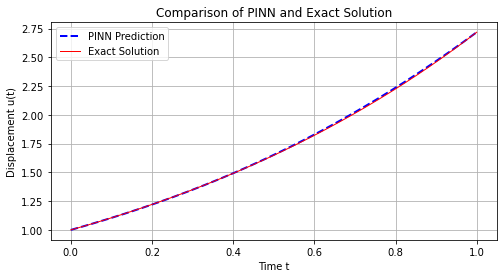

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ===================== 1. Define Neural Network Model (Enforcing Boundary Conditions) =====================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),          # Input layer: 1 neuron
            nn.Tanh(),
            nn.Linear(40, 40),         # Deeper network architecture
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )
    
    def forward(self, x):
        # Base solution A(x) = 1 + (e-1)x, strictly satisfying boundary conditions y(0)=1, y(1)=e
        A = 1 + (np.e - 1) * x
        # Neural network output N(x), multiplied by x(1-x) to ensure zero residual at boundaries
        N = self.net(x)
        return A + x * (1 - x) * N

# ===================== 2. Initialize Model and Optimizer =====================
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=500, factor=0.5)

# ===================== 3. Generate Training Data =====================
epsilon = 1e-6  # Avoid numerical issues at x=0
N_train = 1000  # Number of internal points

# Internal point sampling (increased density near x=0)
x_f = torch.linspace(0.0 + epsilon, 1.0 - epsilon, N_train).reshape(-1, 1)
x_f.requires_grad = True  # Need to compute gradients

# ===================== 4. Training Loop =====================
loss_history = []
for epoch in range(10000):  # Increased number of training epochs
    optimizer.zero_grad()
    
    # --------------- Forward Pass ---------------
    y_pred = model(x_f)
    
    # --------------- Compute Derivatives ---------------
    dy_dx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_f,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]
    
    d2y_dx2 = torch.autograd.grad(
        outputs=dy_dx,
        inputs=x_f,
        grad_outputs=torch.ones_like(dy_dx),
        create_graph=True
    )[0]
    
    # --------------- Compute Equation Residual ---------------
    # Handle division by zero: replace values near 0 in x_f with epsilon
    x_safe = torch.where(x_f < epsilon, torch.ones_like(x_f)*epsilon, x_f)
    residual = d2y_dx2 + ((1 - 2*x_safe)/x_safe * dy_dx) + ((x_safe - 1)/x_safe * y_pred)
    loss = torch.mean(residual**2)  # Only need to minimize residual
    
    # --------------- Backward Propagation and Optimization ---------------
    loss.backward()
    optimizer.step()
    scheduler.step(loss)  # Dynamic learning rate adjustment
    
    loss_history.append(loss.item())
    
    # Print training status every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | Loss: {loss.item():.3e} | LR: {optimizer.param_groups[0]['lr']:.1e}")

# ===================== 5. Testing and Visualization =====================
# Generate test data (including x=0 and x=1)
x_test = torch.linspace(0, 1, 1000).reshape(-1, 1)
y_pred = model(x_test).detach().numpy()
y_exact = np.exp(x_test.numpy())

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
plt.figure(figsize=(8, 4))
plt.plot(x_test, y_pred, 'b--', linewidth=2, label='PINN Prediction')
plt.plot(x_test, y_exact, 'r-', linewidth=1, label='Exact Solution')
plt.xlabel('Time t')
plt.ylabel('Displacement u(t)')
plt.legend()
plt.title('Comparison of PINN and Exact Solution')
plt.grid(True)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9998668632177521, mae_pinn: 0.004222654737532139, rmse_pinn: 0.005720744840800762, inf_norm_pinn: 0.01053309440612793


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_13.csv', index=False)
print(" pinn_13.csv")

数据已保存至 pinn_13.csv
